# 나만의 회귀 모델(다중선형회귀 모델) 만들기

In [1]:
# 데이터 전처리 패키지
import numpy as np
import pandas as pd

# 기계학습 모델 구축 및 평가 패키지
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt

boston = pd.read_csv("house_price.csv") #보스턴 데이터 불러오기

# Data Description
* 활용 데이터: 1978년 Boston 지역의 주택 가격에 대한 데이터
* 데이터 구조: [506 x 14]
    * 데이터: 1978년 보스턴 주택 가격
    * 관측치 개수(행): 506개
    * 변수 개수: 설명변수 13개 / 반응변수 1개
        * **독립 변수** (원인: 예측값을 설명할 수 있는 변수)
            * CRIM: 범죄율
            * INDUS: 비소매상업지역 면적 비율
            * NOX: 일산화질소 농도
            * RM: 주택당 방 수
            * LSTAT: 인구 중 하위 계층 비율
            * B: 인구 중 흑인 비율
            * PTRATIO: 학생/교사 비율
            * ZN: 25,000 평방피트 초과 거주지역 비율
            * CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
            * AGE: 1940년 이전에 건축된 주택의 비율
            * RAD: 방사형 고속도로까지의 거리
            * DIS: 직업센터의 거리
            * TAX: 재산세율
        * **종속 변수** (결과: 예측하고자 하는 값)
            * MEDV: 주택가격

# EDA

In [2]:
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT.MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4,0
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6,0
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9,0
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0,0


* CAT.MEDV는 MEDV와 서로 상관계수가 높은 편임.
* 변수 간 상관계수가 크면 다중공선성 문제 발생 가능 => CAT.MEDV를 drop 하기

In [3]:
# CAT.MEDV를 drop하기
boston.drop(labels='CAT.MEDV', axis=1, inplace=True)

# 데이터 확인
boston.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


# 다중공선성 확인

다중공선성 확인 - heatmap 이용

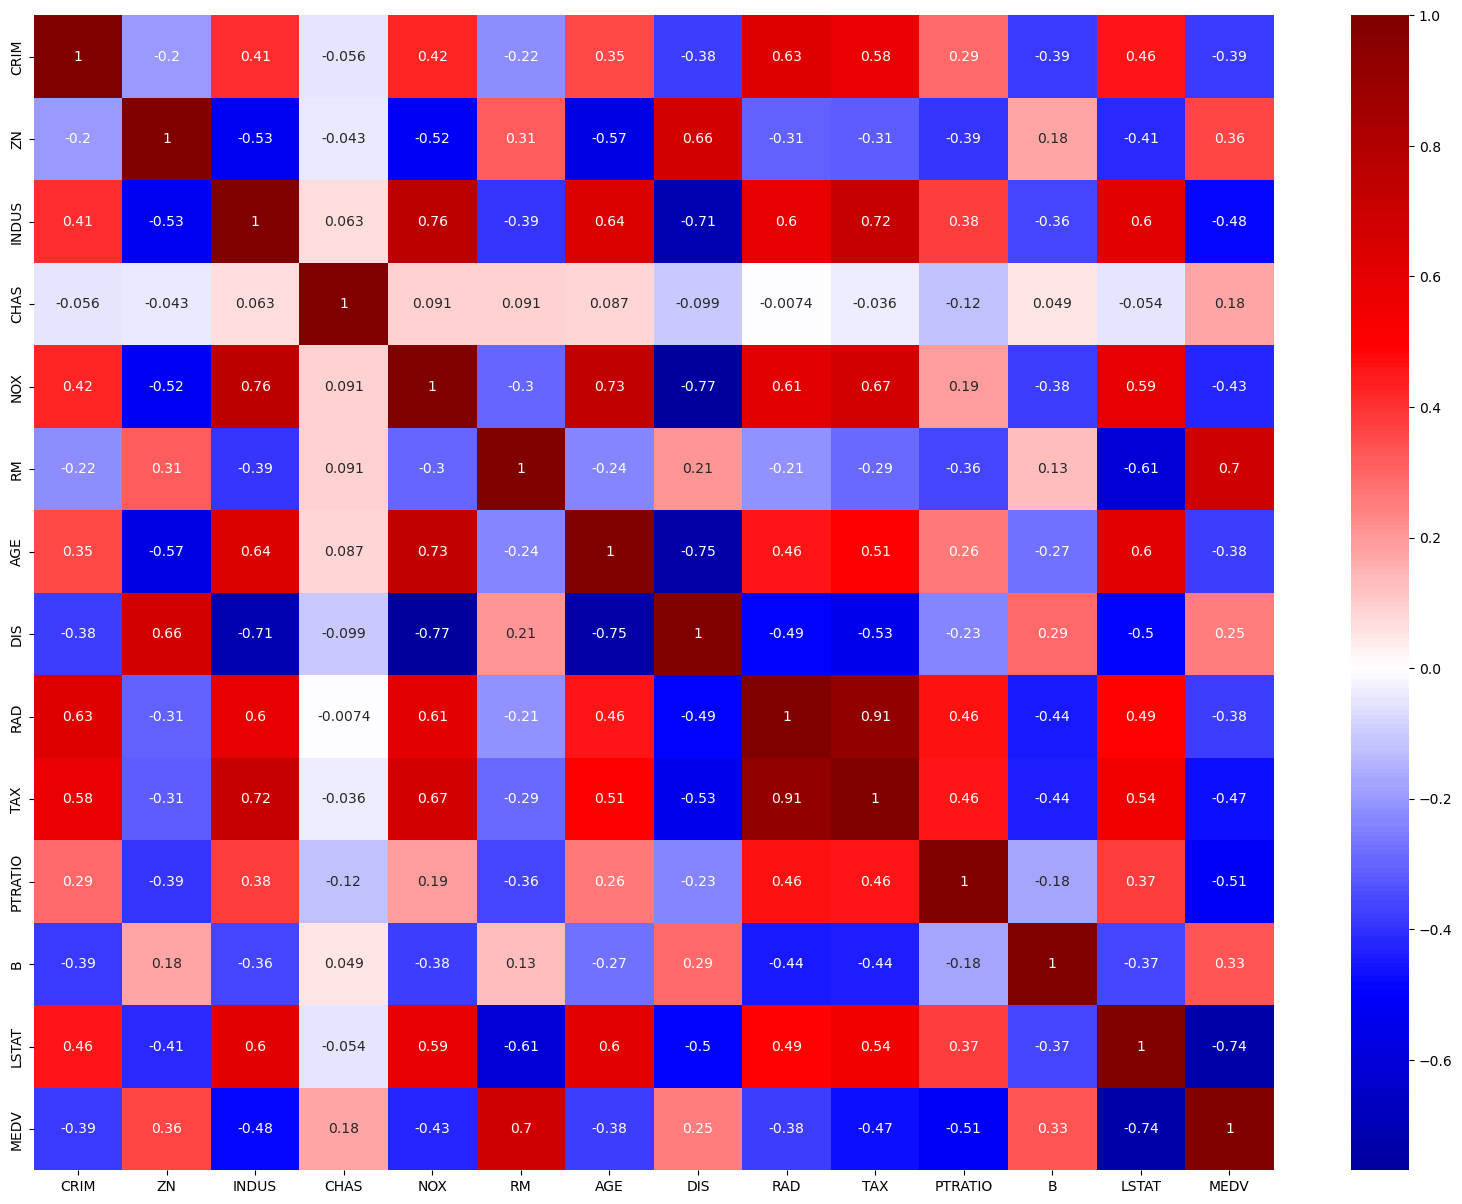

In [11]:
plt.figure(figsize=(20,15))

# center=0으로 설정해줌
sns.heatmap(boston.corr(), annot=True, cmap='seismic', center=0)
plt.show()

* CHAS는 다른 변수들과 상관성이 낮다. <br> <br>
* MEDV과 상관성이 높은 변수는?
    * LSTAT (-0.74, 음의 상관관계)
    * RM (0.7, 양의 상관관계)  <br> <br>
* 특히 상관성이 높은 변수들의 조합은?
    * RAD와 TAX (0.91, 양의 상관관계)
    * NOX와 DIS (-0.77, 음의 상관관계)
    * NOX와 INDUS (0.76, 양의 상관관계)
    * AGE와 DIS (-0.75, 음의 상관관계)  <br> <br>
* LSTAT와 상관성이 높은 변수는?(MEDV 제외)
    * RM (-0.61, 음의 상관관계)
    * INDUS (0.6, 양의 상관관계)
    * AGE (0.6, 양의 상관관계)
    * NOX (0.59, 양의 상관관계)  <br> <br>
* RM와 상관성이 높은 변수는?(MEDV 제외)
    * LSTAT (0.74, 음의 상관관계)

### ➡️ (1) CHAS 변수 (찰스강의 경계에 위치한 경우는 1, 아니면 0) 제거하기

In [12]:
# CHAS를 drop하기
boston.drop(labels='CHAS', axis=1, inplace=True)

# 데이터 확인
boston.head(3)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


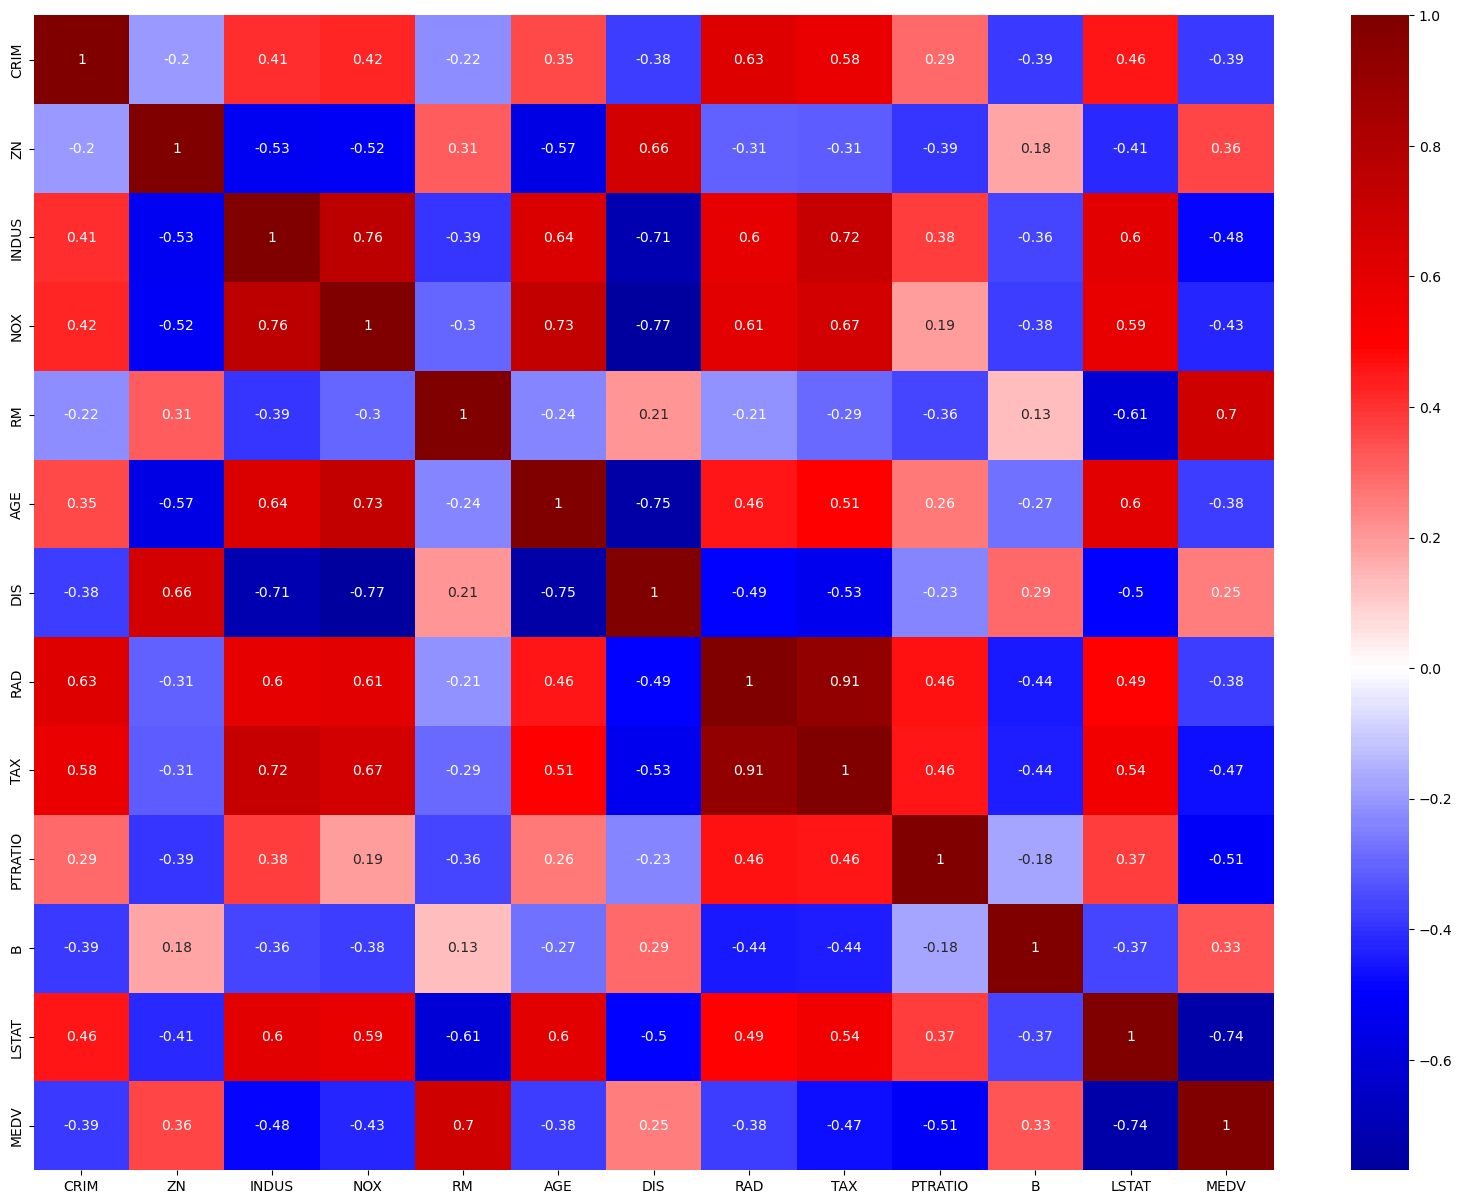

In [13]:
plt.figure(figsize=(20,15))

# center=0으로 설정해줌
sns.heatmap(boston.corr(), annot=True, cmap='seismic', center=0)
plt.show()

### ➡️ (2) RAD와 TAX를 묶을 수 있을까? (PCA)
* RAD: 방사형 고속도로까지의 거리
* TAX: 재산세율

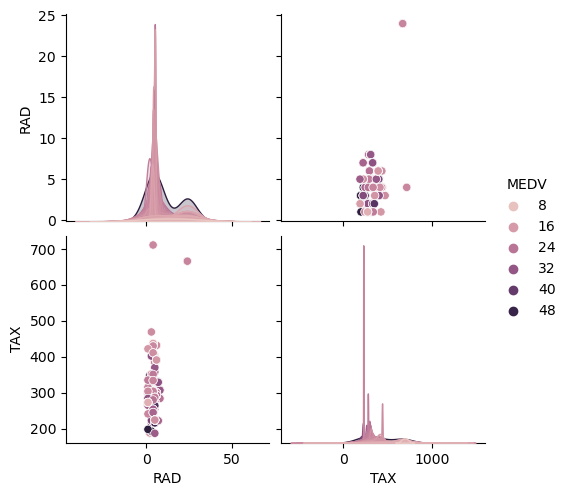

In [18]:
fig = sns.pairplot(boston,hue='MEDV', vars=['RAD', 'TAX'])

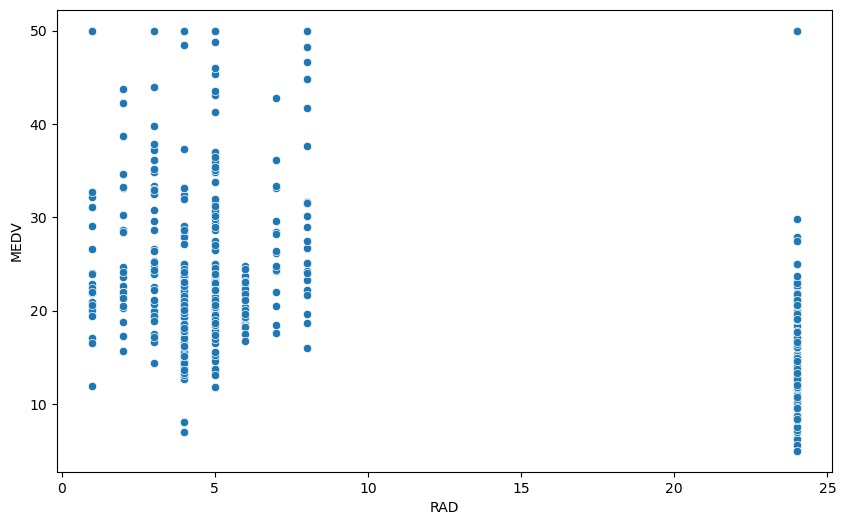

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=boston['RAD'], y=boston['MEDV'])
plt.show()

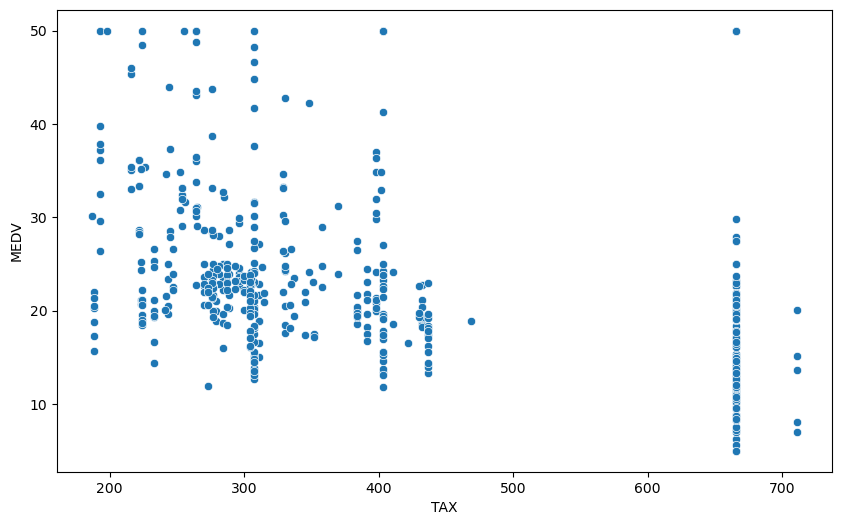

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=boston['TAX'], y=boston['MEDV'])
plt.show()

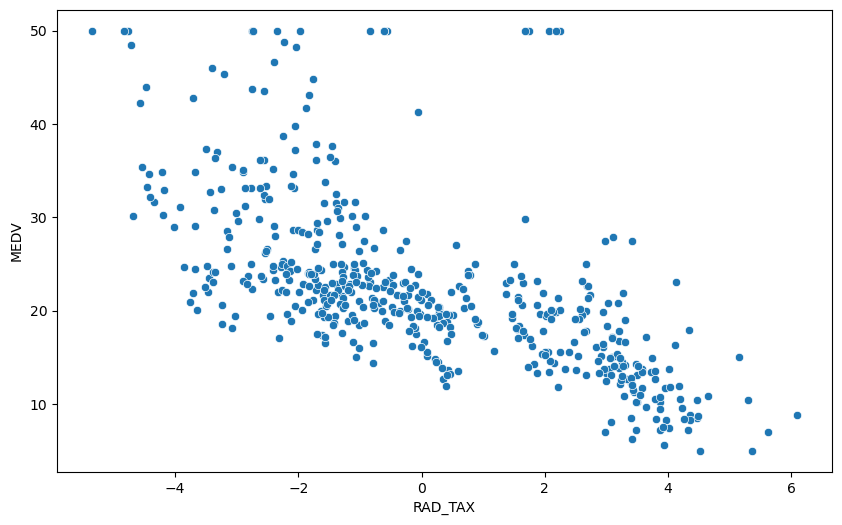

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

boston['RAD_TAX'] = X_pca

plt.figure(figsize=(10,6))
sns.scatterplot(x=boston['RAD_TAX'], y=boston['MEDV'])
plt.show()

In [30]:
boston.head(3)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,RAD_TAX
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,-1.850648
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,-1.299083
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,-2.079077


In [31]:
# RAD_TAX만 남기고, RAD와 TAX는 삭제하기
boston.drop(['RAD', 'TAX'], axis=1, inplace=True)

In [32]:
boston.head(3)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,PTRATIO,B,LSTAT,MEDV,RAD_TAX
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,15.3,396.90,4.98,24.0,-1.850648
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,17.8,396.90,9.14,21.6,-1.299083
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,17.8,392.83,4.03,34.7,-2.079077


다른 변수들도 pca 하고 싶은데.. 약간 애매하게 생긴 것 같아서 그냥 안 해야겠다..

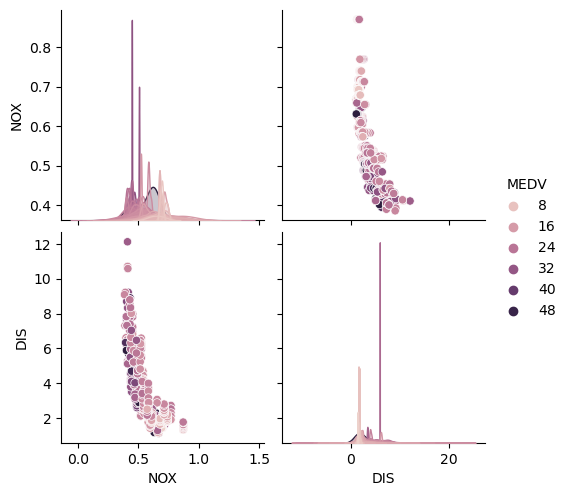

In [35]:
fig = sns.pairplot(boston,hue='MEDV', vars=['NOX', 'DIS'])

모델 학습하고 평가하기

In [33]:
X = boston.drop(labels='MEDV', axis=1)
y = boston['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

from sklearn.linear_model import LinearRegression

lr_skl = LinearRegression()
lr_skl.fit(X_train, y_train)
y_pred_skl = lr_skl.predict(X_test)

test_mse_skl = mean_squared_error(y_test, y_pred_skl)
test_mae_skl = mean_absolute_error(y_test, y_pred_skl)
test_r2_skl = r2_score(y_test, y_pred_skl)


X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)
model_trained = model.fit()


print('Testing MSE: {:.3f}'.format(test_mse_skl))
print('Testing MAE: {:.3f}'.format(test_mae_skl))
print('Testing R2: {:.3f}'.format(test_r2_skl))

print(model_trained.summary())

Testing MSE: 25.265
Testing MAE: 3.667
Testing R2: 0.698
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     109.5
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          3.64e-112
Time:                        23:39:49   Log-Likelihood:                -1185.9
No. Observations:                 404   AIC:                             2396.
Df Residuals:                     392   BIC:                             2444.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

테스트 데이터로 모델 성능 평가해보기

이 회귀 모델은 test 데이터에 대해 69.8퍼센트 정도의 설명력을 보여준다! <br>
생각보다 다중공선성도 계속 높고 AIC, BIC 지수도 높은 것 같아서 아쉽다... <br>
처음에는 그냥 실습 코드처럼 drop만 하는 모델을 만들었었는데 생각보다 R-squared가 낮아서 새롭게 pca를 도전해봤다. <br>
p값 높은 거 drop을 추가로 하면 더 괜찮은 모델이 될 것 같긴 한데... 시간이 부족해서 제출하고 나서 해봐야겠다 😭😭